# Metis Project 1 - MTA Exploratory Data Analysis

MTA would like to introduce new experimental advertising panels at their stations. First 10 systems will be installed in September 2022, which seems to be perfect timing to reach Christmas buyers.
MTA representatives contacted me to identify 10 stations that could fully show potential of new advertising medium during September - December period.



# DATA PREPARATION

In [30]:
#Importing libraries

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sqlalchemy as db
from sqlalchemy import create_engine

%matplotlib inline


In [31]:
#Importing turnstile data from SQL database with SQLAlchemy

engine = create_engine("sqlite:///mta_data.db")

turnstiles_df = pd.read_sql('SELECT * FROM mta_data;', engine)
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,00:00:00,REGULAR,7714568,2706545
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,04:00:00,REGULAR,7714583,2706554
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,08:00:00,REGULAR,7714590,2706575
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,12:00:00,REGULAR,7714641,2706648
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,16:00:00,REGULAR,7714728,2706690


##PREVIOUSLY USED BACKUP METHOD - Importing turnstile data from SQL database

conn = sqlite3.connect('mta_data.db') 
          
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM mta_data
                               ''', conn)

turnstiles_df = pd.DataFrame(sql_query, columns = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES'])

turnstiles_df.head()


#PREVIOUSLY USED BACKUP METHOD - Downloading turnstile data directly

def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190907, 190914, 190921, 190928, 191005, 191012, 191019, 191026, 191102, 191109, 191116, 191123, 191130, 191207, 191214, 191221, 191228, 210904, 210911, 210918, 210925, 211002, 211009,211016, 211023, 211106, 211113, 211120, 211127, 211204, 211211, 211218, 211225, 220101, 220108, 220115, 220122, 220129, 220205, 220212, 220219, 220226, 220305, 220312, 220319, 220326, 220402, 220409, 220416, 220423, 220430, 220507, 220514, 220521, 220528]

turnstiles_df = get_data(week_nums)


To clean MTA code I use methods provided in this course, with small adjustments.

In [32]:
#Cleaning columns names

turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]


In [33]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,00:00:00,REGULAR,7714568,2706545
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,04:00:00,REGULAR,7714583,2706554
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,08:00:00,REGULAR,7714590,2706575
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,12:00:00,REGULAR,7714641,2706648
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,16:00:00,REGULAR,7714728,2706690


In [34]:
#Extracting and reformating DATE and TIME columns to datetime format

turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

turnstiles_df["DATE"] = pd.to_datetime(turnstiles_df.DATE, 
                                            format="%m/%d/%Y")


In [35]:
#Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique (ENRIES)

(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()


,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
11609960,S101,R070,00-00-02,ST. GEORGE,2021-09-27 08:00:00,2
9602928,R285,R308,00-00-00,MT EDEN AV,2019-11-06 07:00:00,2
9602930,R285,R308,00-00-00,MT EDEN AV,2019-11-06 15:00:00,2
9602931,R285,R308,00-00-00,MT EDEN AV,2019-11-06 19:00:00,2
9602932,R285,R308,00-00-00,MT EDEN AV,2019-11-06 23:00:00,2


In [36]:
#Checking specific case to better understand the problem

mask = ((turnstiles_df["C/A"] == "S101") & 
(turnstiles_df["UNIT"] == "R070") & 
(turnstiles_df["SCP"] == "00-00-02") & 
(turnstiles_df["STATION"] == "ST. GEORGE") &
(turnstiles_df["DATE_TIME"].dt.date == dt.datetime(2021, 9, 3).date()))

turnstiles_df[mask].head()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
8200149,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,00:00:00,REGULAR,1396478,324,2021-09-03 00:00:00
8200150,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,00:00:00,RECOVR AUD,1213528,140,2021-09-03 00:00:00
8200151,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,04:00:00,REGULAR,1396480,324,2021-09-03 04:00:00
8200152,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,08:00:00,REGULAR,1396536,324,2021-09-03 08:00:00
8200153,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,08:00:00,RECOVR AUD,1213576,140,2021-09-03 08:00:00


In [37]:
#Dropping the duplicate entries

turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)


In [38]:
#Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique (ENRIES)

(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)


,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31 00:00:00,1
7802070,R141,R031,00-00-00,34 ST-PENN STA,2022-01-21 15:00:00,1
7802050,R141,R031,00-00-00,34 ST-PENN STA,2022-01-18 07:00:00,1
7802051,R141,R031,00-00-00,34 ST-PENN STA,2022-01-18 11:00:00,1
7802052,R141,R031,00-00-00,34 ST-PENN STA,2022-01-18 15:00:00,1


In [39]:
# Droping Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored

turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")


In [40]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,DATE_TIME
211706,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,21:00:00,0,2022-05-27 21:00:00
211705,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,17:00:00,0,2022-05-27 17:00:00
211704,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,13:00:00,0,2022-05-27 13:00:00
211703,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,09:00:00,0,2022-05-27 09:00:00
211702,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2022-05-27,05:00:00,0,2022-05-27 05:00:00


In [41]:
#Finding daily ENTRIES as a base for calculations, grabbing the highest reading of the day

turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.max())


In [42]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31,7183842
1,A002,R051,02-00-00,59 ST,2019-09-01,7184559
2,A002,R051,02-00-00,59 ST,2019-09-02,7185132
3,A002,R051,02-00-00,59 ST,2019-09-03,7186355
4,A002,R051,02-00-00,59 ST,2019-09-04,7187672


In [43]:
#Creating columns with previous date and entries number. As entries records are cumulative, those columns will be used to establish daily entry anjustment.

turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES",]
                                                       .apply(lambda grp: grp.shift(1)))


/var/folders/vr/n5366ypx2jd2xjt2gj07clnh0000gn/T/ipykernel_14243/1050101385.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [44]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31,7183842,NaT,NaN
1,A002,R051,02-00-00,59 ST,2019-09-01,7184559,2019-08-31,7183842.0
2,A002,R051,02-00-00,59 ST,2019-09-02,7185132,2019-09-01,7184559.0
3,A002,R051,02-00-00,59 ST,2019-09-03,7186355,2019-09-02,7185132.0
4,A002,R051,02-00-00,59 ST,2019-09-04,7187672,2019-09-03,7186355.0


In [45]:
#Dropping the rows with the earliest date in the df

turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [46]:
#Calculating entries, fixing negative counts, and ones over 50000, getting diference between entries count and entries count from day before

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
#        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=50000)


In [47]:
#Dropping "ENTRIES", "PREV_DATE" and "PREV_ENTRIES" columns.  To prevent errors in multiple run of cell, errors on drop is ignored

turnstiles_daily = turnstiles_daily.drop(["ENTRIES", "PREV_DATE", "PREV_ENTRIES"], axis=1, errors="ignore")

turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2019-09-01,717.0
2,A002,R051,02-00-00,59 ST,2019-09-02,573.0
3,A002,R051,02-00-00,59 ST,2019-09-03,1223.0
4,A002,R051,02-00-00,59 ST,2019-09-04,1317.0
5,A002,R051,02-00-00,59 ST,2019-09-05,1353.0


# DATA ANALYSE

In [48]:
#Generating df's of station daily traffic in specified periods

station_daily_2019_sept_dec = turnstiles_daily[(turnstiles_daily["DATE"].dt.date >= dt.datetime(2019, 9, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2020, 1, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

station_daily_2021_sept_dec = turnstiles_daily[(turnstiles_daily["DATE"].dt.date >= dt.datetime(2021, 9, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2022, 1, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

station_daily_2022_jan_may = turnstiles_daily[(turnstiles_daily["DATE"].dt.date >= dt.datetime(2022, 1, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2022, 6, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

station_daily_2022_jan_may.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2022-01-01,3013.0
1,1 AV,2022-01-02,3662.0
2,1 AV,2022-01-03,6782.0
3,1 AV,2022-01-04,7074.0
4,1 AV,2022-01-05,7361.0


In [49]:
#Identyfying 10 stations with highest number of entries in specified periods

top_10_stations_2019_sept_dec = station_daily_2019_sept_dec.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index().head(10)

top_10_stations_2021_sept_dec = station_daily_2021_sept_dec.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index().head(10)

top_10_stations_2022_jan_may = station_daily_2022_jan_may.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index().head(10)

top_10_stations_2022_jan_may

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,6761005.0
1,GRD CNTRL-42 ST,5311000.0
2,34 ST-HERALD SQ,5150211.0
3,23 ST,4833367.0
4,42 ST-PORT AUTH,4770424.0
5,86 ST,4741748.0
6,14 ST-UNION SQ,4272072.0
7,125 ST,4188586.0
8,TIMES SQ-42 ST,4172535.0
9,FULTON ST,3982469.0


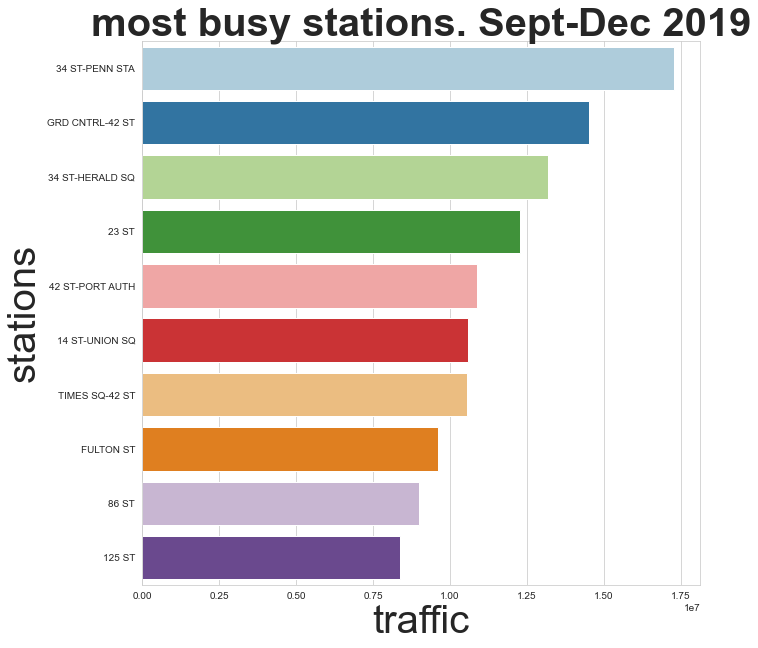

In [50]:
#Creating horizontal bar plots of 10 stations with highest number of entries in specified periods

plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.barplot(x = 'DAILY_ENTRIES', y = 'STATION', palette="Paired", data = top_10_stations_2019_sept_dec)
plt.title('most busy stations. Sept-Dec 2019', weight='bold', fontsize = 40)
plt.ylabel('stations', fontsize = 40)
plt.xlabel('traffic', fontsize = 40);
plt.savefig('most_busy_stations_Sept_Dec_2019', transparent=True, bbox_inches = 'tight')

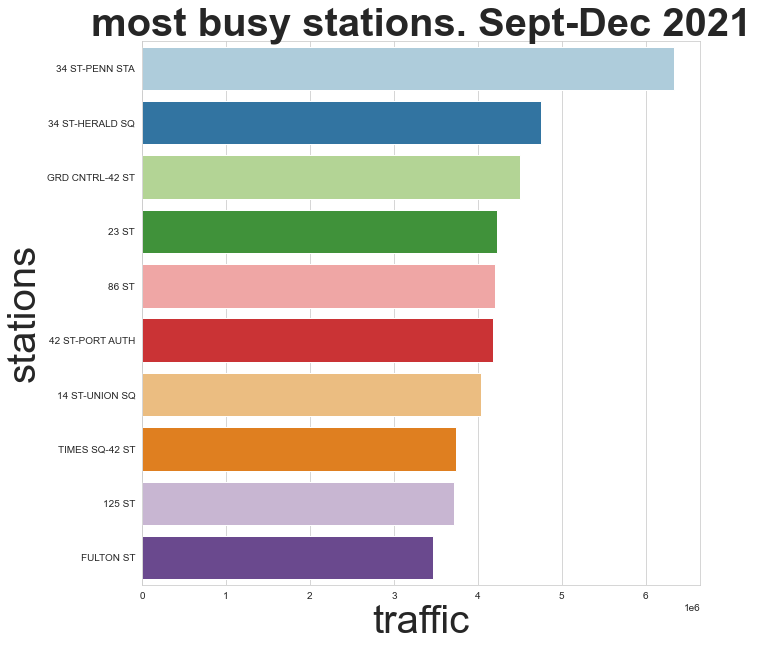

In [51]:
plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.barplot(x = 'DAILY_ENTRIES', y = 'STATION', palette="Paired", data = top_10_stations_2021_sept_dec)
plt.title('most busy stations. Sept-Dec 2021', weight='bold', fontsize = 40)
plt.ylabel('stations', fontsize = 40)
plt.xlabel('traffic', fontsize = 40);
plt.savefig('most_busy_stations_Sept_Dec_2021', transparent=True, bbox_inches = 'tight')

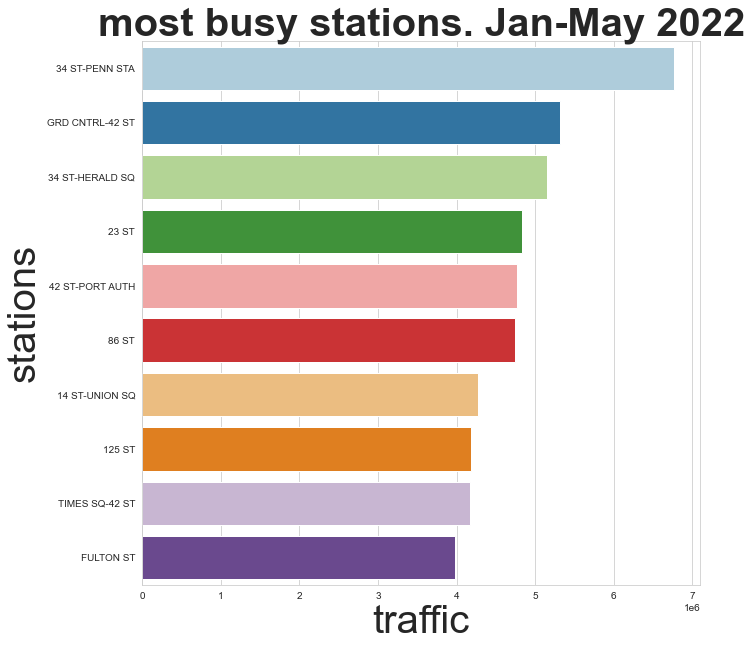

In [52]:
plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.barplot(x = 'DAILY_ENTRIES', y = 'STATION', palette="Paired", data = top_10_stations_2022_jan_may)
plt.title('most busy stations. Jan-May 2022', weight='bold', fontsize = 40)
plt.ylabel('stations', fontsize = 40)
plt.xlabel('traffic', fontsize = 40);
plt.savefig('most_busy_stations_Jan_May_2022', transparent=True, bbox_inches = 'tight')

In [53]:
#As FULTON ST is at the bottom of the 2022 list, taking closer look and trying to identyfy trend

fulton_st_daily = turnstiles_daily[(turnstiles_daily["STATION"] == "FULTON ST") & (turnstiles_daily["DATE"].dt.date >= dt.datetime(2021, 9, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2022, 6, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
fulton_st_monthly = fulton_st_daily.groupby(fulton_st_daily.DATE.dt.month)['DAILY_ENTRIES'].sum().reset_index()
fulton_st_monthly

,DATE,DAILY_ENTRIES
0,1,661305.0
1,2,727034.0
2,3,908098.0
3,4,875768.0
4,5,810264.0
5,9,820322.0
6,10,897380.0
7,11,876731.0
8,12,866141.0


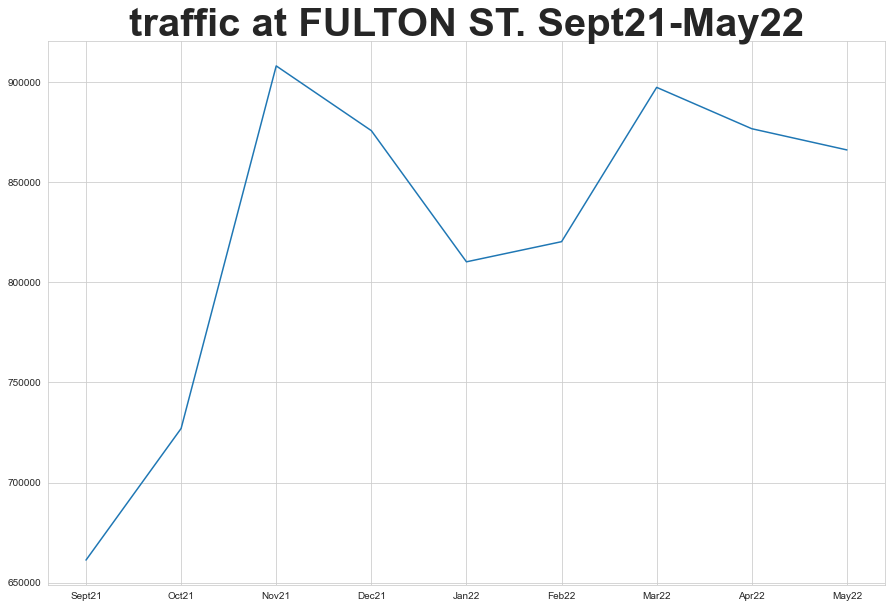

In [54]:
#Creating plot of FULTON ST traffic during Sept21-May22. As it is last one at top 10 list, checking how stable is the traffic

plt.figure(figsize=(15,10))
plt.plot(fulton_st_monthly.index, fulton_st_monthly['DAILY_ENTRIES'])
#plt.ylabel('traffic')
#plt.xlabel('Date')
plt.xticks([ 0, 1, 2, 3, 4, 5, 6, 7, 8], ['Sept21', 'Oct21', 'Nov21', 'Dec21', 'Jan22', 'Feb22', 'Mar22', 'Apr22', 'May22'])
plt.title('traffic at FULTON ST. Sept21-May22', weight='bold', fontsize = 40)
plt.savefig('traffic_at_FULTON_ST_Sept21-May22', transparent=True, bbox_inches = 'tight')


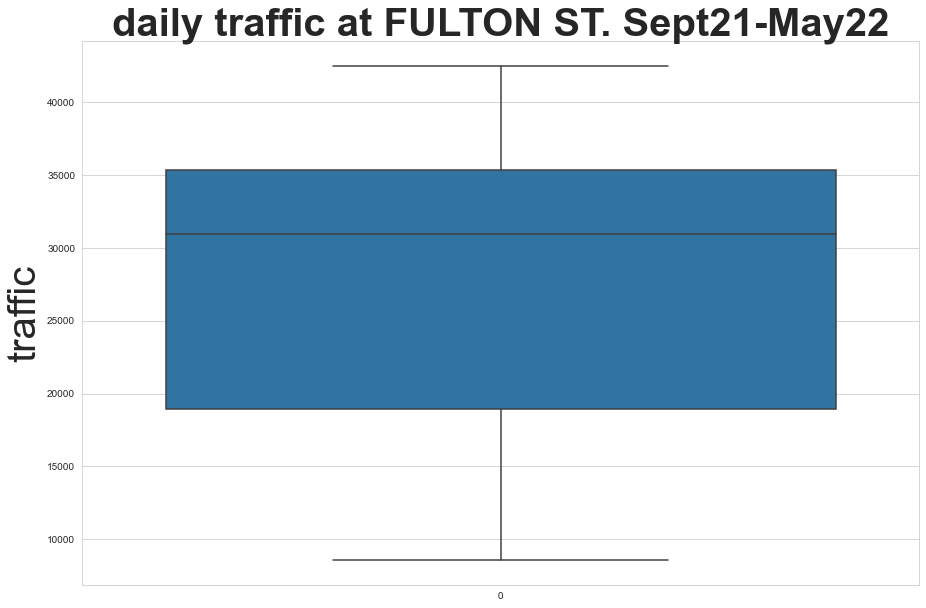

In [55]:
#Creating box plot of FULTON ST traffic during Sept21-May22. As it is last one at top 10 list, checking how stable is the traffic


plt.figure(figsize = [15,10])
sns.set_style("whitegrid")
plt.ylabel('traffic', fontsize = 40)
sns.boxplot(data = fulton_st_daily['DAILY_ENTRIES']);
plt.title('daily traffic at FULTON ST. Sept21-May22', weight='bold', fontsize = 40)
plt.savefig('daily_traffic_at_FULTON_ST_Sept21-May22', transparent=True, bbox_inches = 'tight')